In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load the dataset

In [2]:
df = pd.read_csv('../data/StudentPerformanceFactors.csv')
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


Preprocessing

In [3]:
df.columns = df.columns.str.lower()

In [4]:
target = 'exam_score'

In [5]:
categorical = df.dtypes[df.dtypes == 'object'].index.to_list()
categorical

['parental_involvement',
 'access_to_resources',
 'extracurricular_activities',
 'motivation_level',
 'internet_access',
 'family_income',
 'teacher_quality',
 'school_type',
 'peer_influence',
 'learning_disabilities',
 'parental_education_level',
 'distance_from_home',
 'gender']

In [6]:
numerical = [x for x in df.columns if x not in categorical + [target]]
numerical

['hours_studied',
 'attendance',
 'sleep_hours',
 'previous_scores',
 'tutoring_sessions',
 'physical_activity']

In [7]:
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_').str.strip()

df.head()

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,low,high,no,7,73,low,yes,0,low,medium,public,positive,3,no,high_school,near,male,67
1,19,64,low,medium,no,8,59,low,yes,2,medium,medium,public,negative,4,no,college,moderate,female,61
2,24,98,medium,medium,yes,7,91,medium,yes,2,medium,medium,public,neutral,4,no,postgraduate,near,male,74
3,29,89,low,medium,yes,8,98,medium,yes,1,medium,medium,public,negative,4,no,high_school,moderate,male,71
4,19,92,medium,medium,yes,6,65,medium,yes,3,medium,high,public,neutral,4,no,college,near,female,70


Exploratory data analysis (EDA)

Dataset Overview

In [8]:
# Number of rows
df[numerical + categorical].shape

(6607, 19)

In [9]:
df[target].describe()

count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: exam_score, dtype: float64

In [10]:
# Drop the row with exam score 101 (100 is max according to data description.)
df = df[df['exam_score'] <= 100]

Missing values

In [11]:
# Columns with NaN values
df.isna().sum()

hours_studied                  0
attendance                     0
parental_involvement           0
access_to_resources            0
extracurricular_activities     0
sleep_hours                    0
previous_scores                0
motivation_level               0
internet_access                0
tutoring_sessions              0
family_income                  0
teacher_quality               78
school_type                    0
peer_influence                 0
physical_activity              0
learning_disabilities          0
parental_education_level      90
distance_from_home            67
gender                         0
exam_score                     0
dtype: int64

In [12]:
# Columns with NaN values
df.isna().sum()[df.isna().sum() > 0]

teacher_quality             78
parental_education_level    90
distance_from_home          67
dtype: int64

In [13]:
# Size and % of records with NaN data
nan_records = int(((df['teacher_quality'].isna()) | (df['parental_education_level'].isna()) | (df['distance_from_home'].isna())).sum())
nan_records, nan_records/len(df)

(229, 0.03466545564638208)

Given that:

- The differences between categories are all around between 66-68, and
- Only ~3.5% of records are missing,

It’s perfectly reasonable (and safe) to replace the NaN values with "Unknown" in this case.

In [14]:
# Replace NaN with "unknown"
df = df.fillna('unknown')

Target Variable Distribution

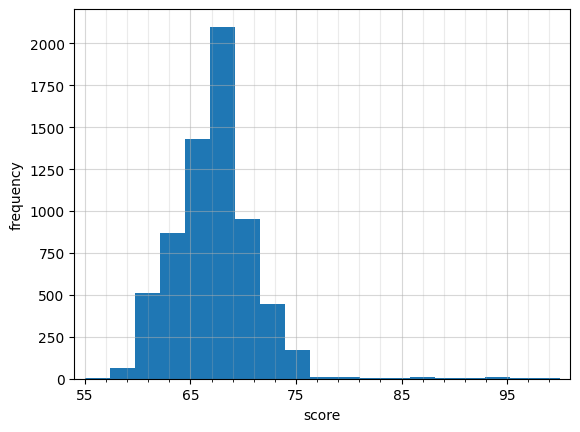

In [15]:
# Distribution of exam_score
major_ticks = range(55,101, 10)
minor_ticks = range(55,101, 2)

plt.hist(df['exam_score'], bins=19)

plt.xlabel('score')
plt.ylabel('frequency')

plt.xlim(54,101)

plt.xticks(major_ticks)
plt.xticks(minor_ticks, minor=True)

# And a corresponding grid
plt.grid(which='both')

# Or if you want different settings for the grids:
plt.grid(which='minor', alpha=0.25)
plt.grid(which='major', alpha=0.5)

plt.show()

In [16]:
df['exam_score'].describe()

count    6606.000000
mean       67.230548
std         3.868502
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       100.000000
Name: exam_score, dtype: float64

Features distribution

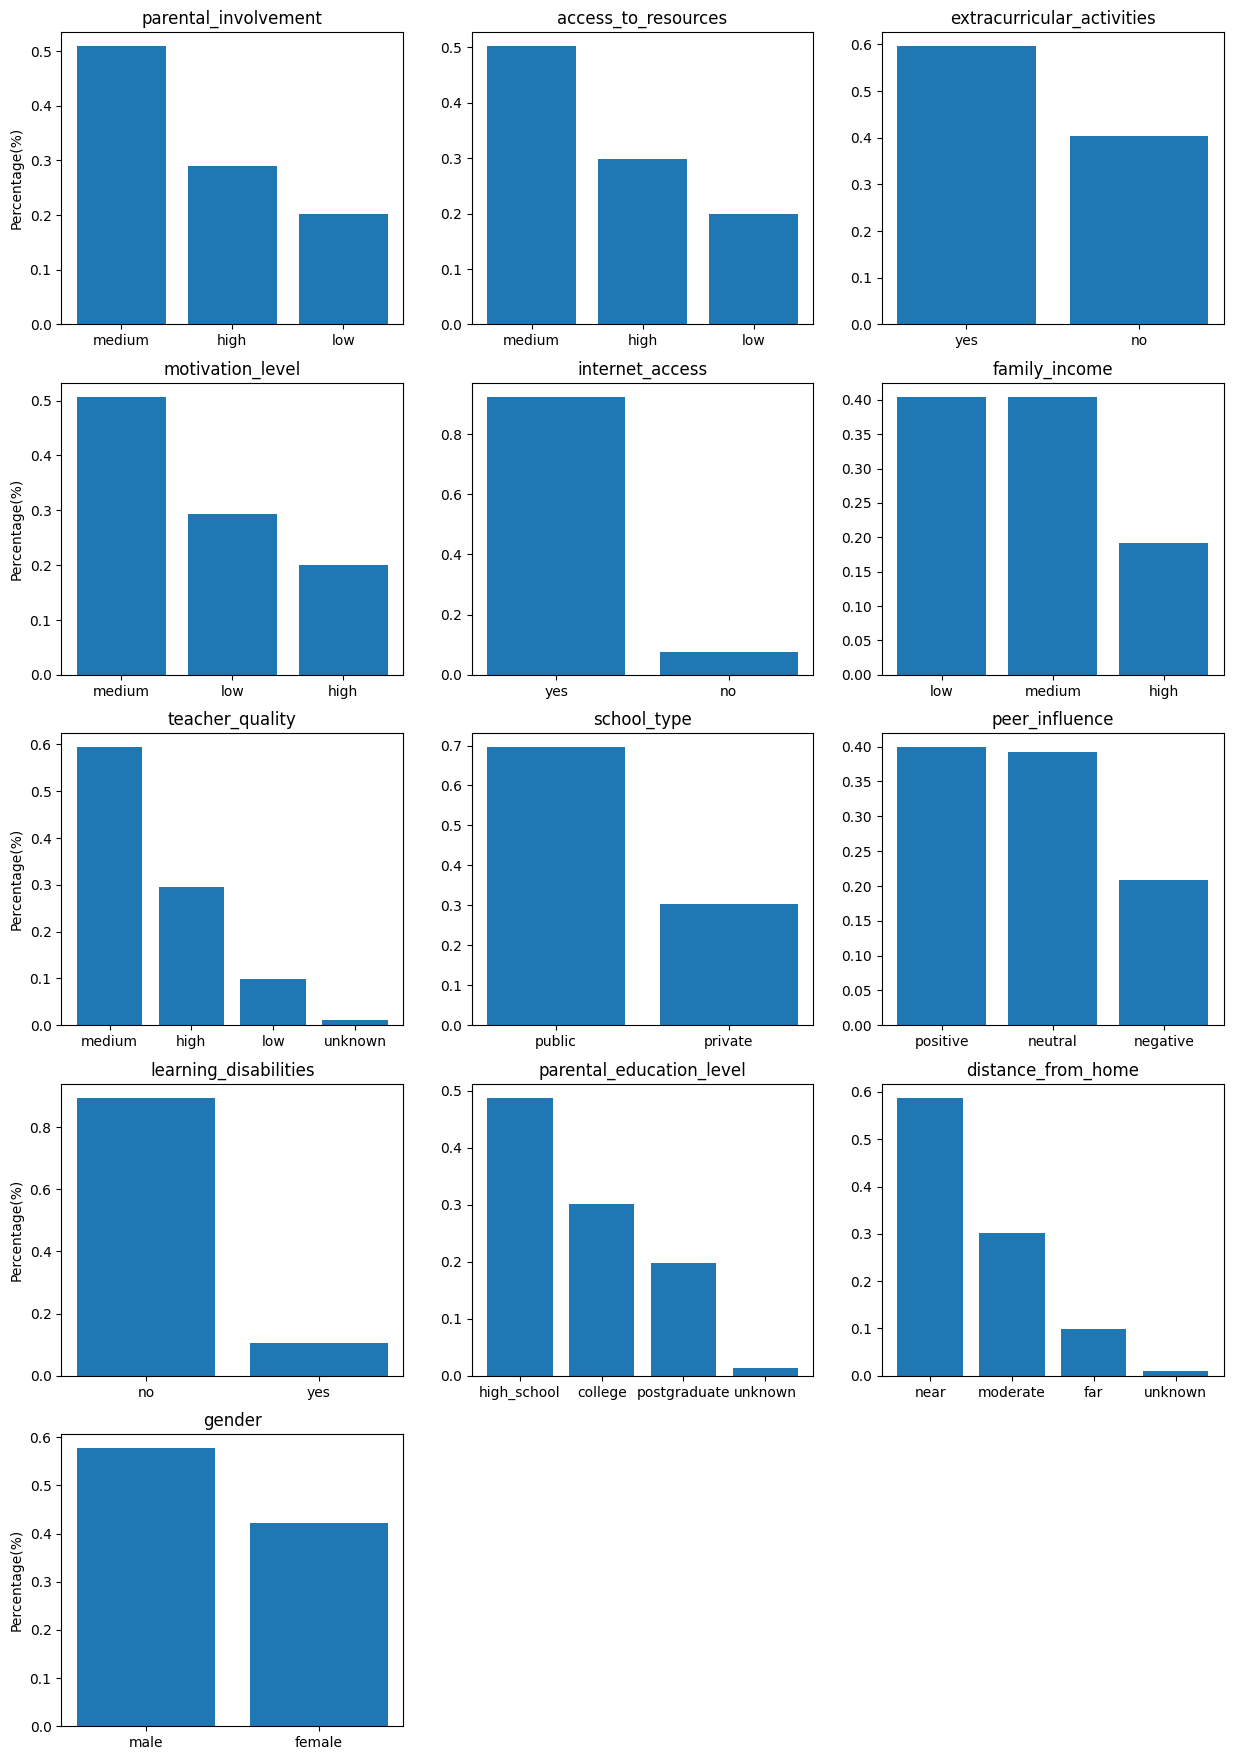

In [21]:
fig, axes = plt.subplots(5, 3, figsize=(15, 22))
counter = 0
for x in range(5):
    for y in range(3):
        if counter < len(categorical):
            frequency = df[categorical[counter]].value_counts(normalize=True)
            axes[x, y].bar(frequency.index, frequency.values)
            axes[x, y].set_title(categorical[counter])
            if y == 0:
                axes[x, y].set_ylabel('Percentage(%)')
        else:
            fig.delaxes(axes[x][y])
        counter += 1
        

plt.show()

Features importance

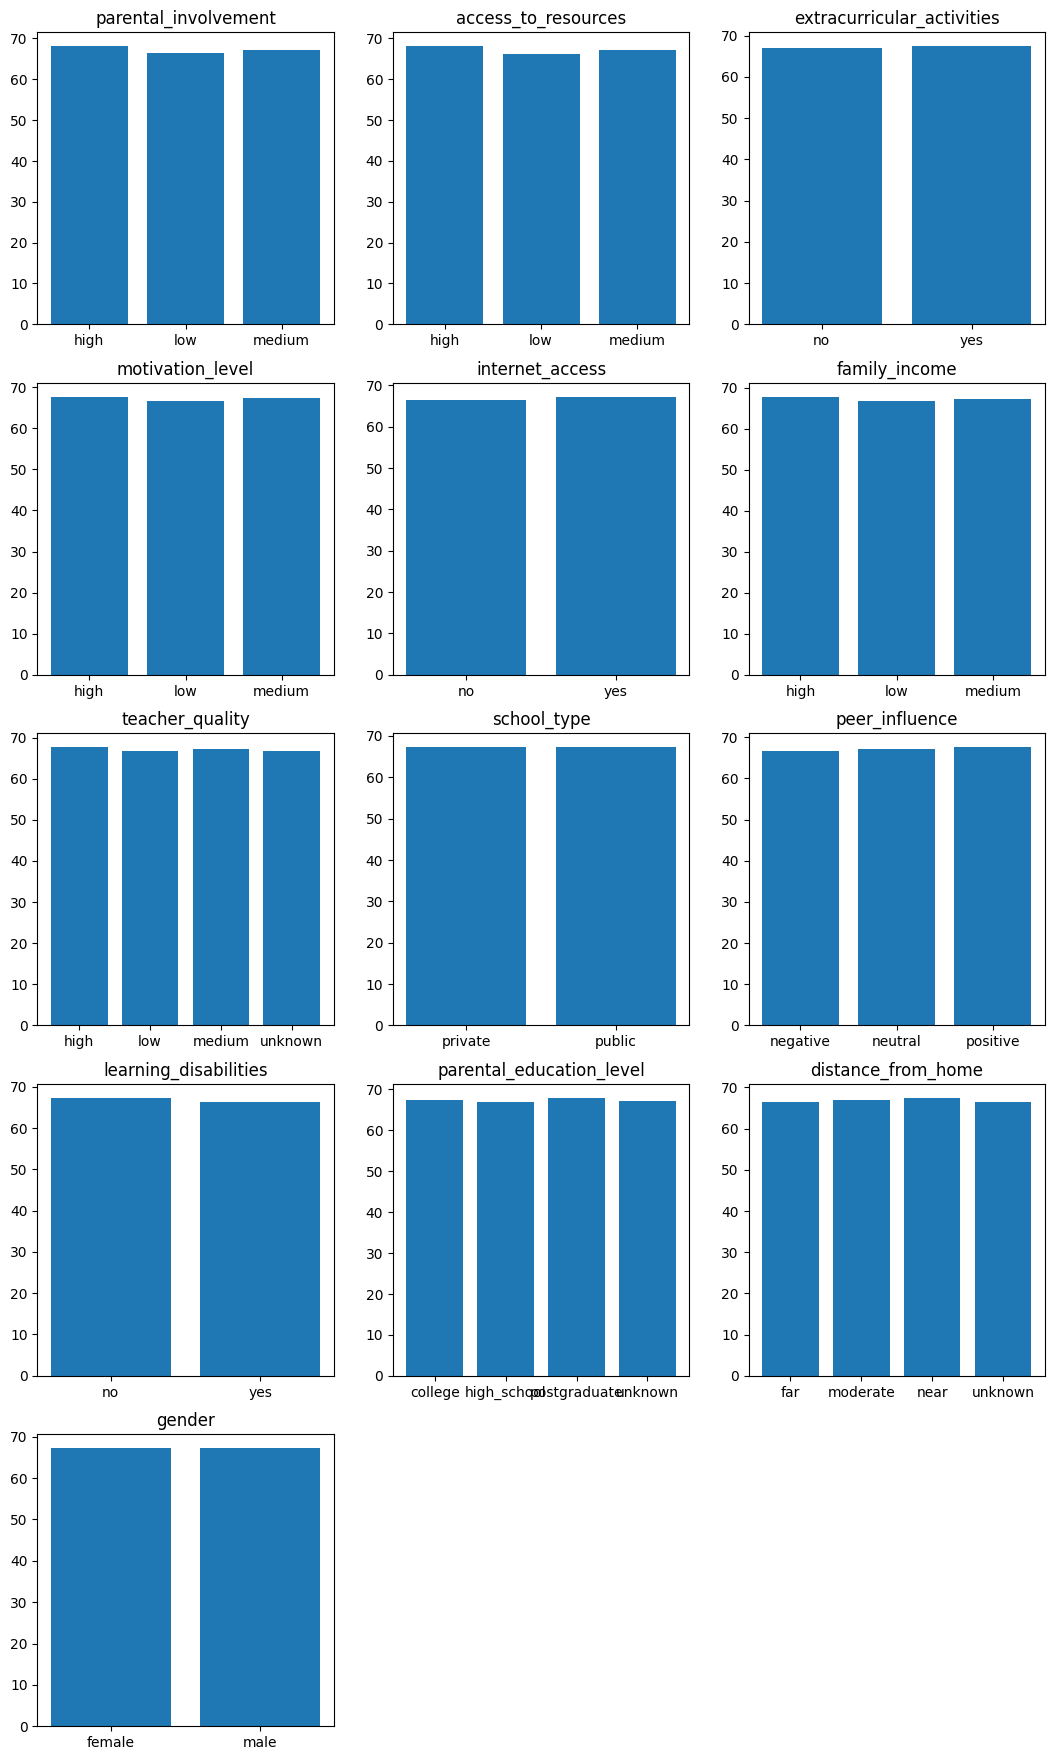

In [153]:
fig, axes = plt.subplots(5, 3, figsize=(13, 22))
counter = 0
for x in range(5):
    for y in range(3):
        if counter < len(categorical):
            distribution = df.groupby(categorical[counter])['exam_score'].mean()
            axes[x, y].bar(distribution.index, distribution.values)
            axes[x, y].set_title(categorical[counter])
        else:
            fig.delaxes(axes[x][y])
        counter += 1

In [125]:
from sklearn.metrics import mutual_info_score

In [126]:
def mutual_info_exam_score(series):
    return mutual_info_score(series, df['exam_score'])

In [127]:
mi = df[categorical].apply(mutual_info_exam_score)
mi.sort_values(ascending=False)

access_to_resources           0.027738
parental_involvement          0.022817
parental_education_level      0.016276
peer_influence                0.013170
distance_from_home            0.013117
family_income                 0.011312
motivation_level              0.010994
teacher_quality               0.010982
learning_disabilities         0.008993
extracurricular_activities    0.006423
gender                        0.004688
internet_access               0.004536
school_type                   0.003773
dtype: float64

Correlation

In [162]:
df[numerical].corrwith(df['exam_score']).abs().sort_values(ascending=False)

attendance           0.582458
hours_studied        0.446514
previous_scores      0.174461
tutoring_sessions    0.153754
physical_activity    0.027943
sleep_hours          0.016194
dtype: float64

In [184]:
import seaborn as sns

<Axes: >

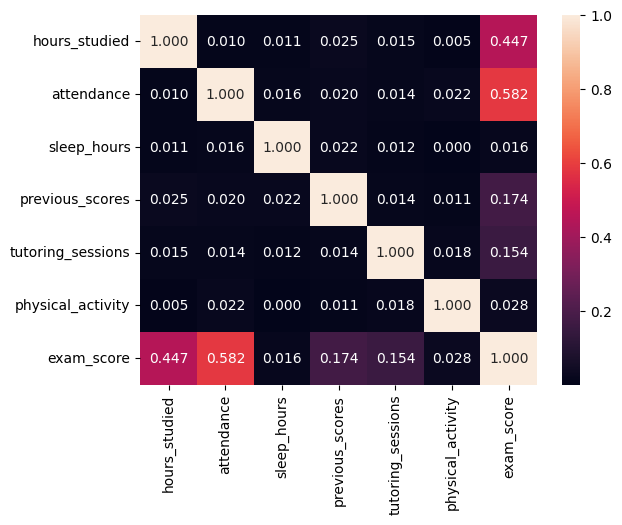

In [185]:
correlations_dict = {}
for n in numerical + [target]:
    correlations = df[numerical + [target]].corrwith(df[n]).abs()
    correlations_dict[n] = {x:y for x, y in zip(numerical + [target], correlations)}

sns.heatmap(pd.DataFrame(correlations_dict), annot=True, fmt='.3f')

Setting up the validation framework

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

len(df_train), len(df_val), len(df_test)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
y_train = df_train['exam_score']
y_val = df_val['exam_score']
y_test = df_test['exam_score']

del df_train['exam_score']
del df_val['exam_score']
del df_test['exam_score']

a. Average ratio

In [ ]:
average_score = df_full_train['exam_score'].mean()
average_score

In [ ]:
from IPython.display import display

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c)['exam_score'].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - average_score
    df_group['ratio'] = df_group['mean'] / average_score
    display(df_group)
    print()
    print()



b. Mutual information

c. Correlation

In [ ]:
numerical = [x for x in df_full_train.columns if x not in categorical + ['exam_score']]
numerical

One-hot encoding

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_full_train = df_full_train['exam_score']


Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

In [ ]:
y_pred = lr_model.predict(X_val)
lr_rmse = root_mean_squared_error(y_val, y_pred)
lr_rmse

In [ ]:
student = df_test.loc[15].to_dict()

X_student = dv.transform(student)
predicted_score = lr_model.predict(X_student)
y_test[15], predicted_score[0]

Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
scores = []

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dtr_model = DecisionTreeRegressor(max_depth=d, random_state=42)
    dtr_model.fit(X_train, y_train)
    y_pred = dtr_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append((d, score))

In [ ]:
columns = ['max_depth', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

In [ ]:
scores = []
for d in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 100, 200, 500]:
        dtr_model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=42)
        dtr_model.fit(X_train, y_train)
        y_pred = dtr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)
        scores.append((d, s, score))

In [ ]:
pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'score']).sort_values(by='score').head(10)

In [ ]:
max_depth = 6
min_samples_leaf = 15

In [ ]:
dtr_model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
dtr_model.fit(X_train, y_train)
y_pred = dtr_model.predict(X_val)
dtr_rmse = root_mean_squared_error(y_val, y_pred)
dtr_rmse

In [ ]:
predicted_score = dtr_model.predict(X_student)
y_test[15], predicted_score[0]

Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
scores = []

for n in range(10, 201, 10):
    rf_model = RandomForestRegressor(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    
    scores.append((n, score))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

In [ ]:
df_scores.sort_values(by='score').head()

In [ ]:
scores = []

for d in [2, 3, 4, 5, 10, 15, None]:
    for n in range(10, 201, 10):
        rfr_model = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=42)
        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, score))

In [ ]:
columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='score').head()

In [ ]:
for d in df_scores['max_depth'].unique():
    if pd.isna(d):
        df_subset = df_scores[df_scores['max_depth'].isna()]
        label = 'max_depth=nan'
    else:
        df_subset = df_scores[df_scores['max_depth'] == d]
        label = f'max_depth={d}'
    
    plt.plot(df_subset['n_estimators'], df_subset['score'], label=label)

plt.legend()

In [ ]:
max_depth = 15

In [ ]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rfr_model = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42)
        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((s, n, score))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             color=col,
             label=f'min_samples_leaf={s}')

plt.legend()

In [ ]:
min_samples_leaf = 3

In [ ]:
scores = []

for n in range(10, 201, 10):
    rfr_model = RandomForestRegressor(n_estimators=n,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rfr_model.fit(X_train, y_train)

    y_pred = rfr_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)

    scores.append((n, score))

In [ ]:
columns = ['n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

In [ ]:
n_estimators = 100

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42)
rfr_model.fit(X_train, y_train)

y_pred = rfr_model.predict(X_val)
rfr_score = root_mean_squared_error(y_val, y_pred)
rfr_score

In [ ]:
predicted_score = rf_model.predict(X_student)
y_test[15], predicted_score

XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, feature_names=features)

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [ ]:
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = xgb_model.predict(dval)


In [ ]:
root_mean_squared_error(y_val, y_pred)

In [ ]:
# XGBoost parameter tuning


In [ ]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [ ]:
scores = {}

In [ ]:
%%capture output
eta = 1 # replace values manually for eta=0.01, eta=0.02, eta=0.05, eta=0.1, eta=0.3, eta=0.5, eta=0.8, eta=1

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}



xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2000,
                  verbose_eval=5,
                  evals=watchlist)


In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
scores.keys()

In [ ]:
for eta in scores.keys():
    df_scores = scores[eta]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=eta)
plt.xlabel('num_boost_round')
plt.ylabel('score')
plt.legend()

In [ ]:
# Remove eta=0.1, eta=0.3, eta=0.5, eta=0.8 and eta=1 for a better visualization.
etas = [x for x in scores.keys() if x not in ['eta=0.1', 'eta=0.3', 'eta=0.5', 'eta=0.8', 'eta=1']]
for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=eta)
plt.xlabel('num_boost_round')
plt.ylabel('score')
plt.legend()

In [ ]:
df_scores = pd.DataFrame()
for key in scores.keys():
    df_tmp = scores[key]
    df_tmp['eta'] = key.split('=')[1]
    df_scores = pd.concat([df_scores, df_tmp])

df_scores.sort_values(by='val_score').head(10)


Best eta after 750 num_boost_round
eta = 0.01

In [ ]:
scores = {}

In [ ]:
%%capture output
max_depth = 10 # replace values manually for max_depth=6, max_depth=3, max_depth=4, max_depth=8, max_depth=10

xgb_params = {
    'eta': 0.01, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2500,
                  verbose_eval=5,
                  evals=watchlist)


In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
scores.keys()

In [ ]:
for max_depth in scores.keys():
    df_scores = scores[max_depth]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=max_depth)
plt.xlabel('num_boost_round')
plt.ylabel('score')
# plt.ylim(2.5, 2.7)
plt.legend()

In [ ]:
# Remove max_depth=10 and zoom the graph between scores of 2.3-2.5 for a better visualization.
max_depths = [x for x in scores.keys() if x not in ['max_depth=10']]
for max_depth in max_depths:
    df_scores = scores[max_depth]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=max_depth)
plt.ylim(2.3, 2.5)
plt.legend()

In [ ]:
df_scores = pd.DataFrame()
for key in scores.keys():
    df_tmp = scores[key]
    df_tmp['max_depth'] = key.split('=')[1]
    df_scores = pd.concat([df_scores, df_tmp])

df_scores.sort_values(by='val_score').head(10)


max_depth = 3 # after num_boost_round 1500. Overfitting after 2000?

In [ ]:
scores = {}

In [ ]:
%%capture output
min_child_weight = 30 # replace values manually for min_child_weight=1, min_child_weight=10, min_child_weight=30

xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': min_child_weight,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2500,
                  verbose_eval=5,
                  evals=watchlist)


In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
scores.keys()

In [ ]:
min_child_weights = [x for x in scores.keys() if x not in []]
for min_child_weight in min_child_weights:
    df_scores = scores[min_child_weight]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=min_child_weight)
plt.ylim(2.3, 2.7)

plt.legend()

In [ ]:
df_scores = pd.DataFrame()
for key in scores.keys():
    df_tmp = scores[key]
    df_tmp['max_depth'] = key.split('=')[1]
    df_scores = pd.concat([df_scores, df_tmp])

df_scores.sort_values(by='val_score').head(10)


min_child_weight = 30 # after aprox. 2000 num_boost_round

In [ ]:
num_boost_rounds = np.linspace(700, 2500, 19).astype('int')
scores = []

for n in num_boost_rounds:
    xgb_params = {
        'eta': 0.01, 
        'max_depth': 3,
        'min_child_weight': 30,
        
        'objective': 'reg:squarederror',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=n)

    y_pred = xgb_model.predict(dval)

    score = root_mean_squared_error(y_val, y_pred)

    scores.append(score)


In [ ]:
for n, s in zip(num_boost_rounds, scores):
    print(n, ' -> ', s)

num_boost_round = 2000

In [ ]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2000)


In [ ]:
y_pred = xgb_model.predict(dval)

In [ ]:
xgb_rmse = root_mean_squared_error(y_val, y_pred)
xgb_rmse

In [ ]:
dstudent = xgb.DMatrix(X_student, feature_names=features)
predicted_score = xgb_model.predict(dstudent)
y_test[15], predicted_score

Build the final model

In [ ]:
lr_rmse, dtr_rmse, rfr_score, xgb_rmse

The best is: Linear Regression Model

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_full_train, y_full_train)

y_pred = lr_model.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_rmse

In [ ]:
df_student = df_test.iloc[52]
student_dict = df_student[categorical + numerical].to_dict()
X_student = dv.transform(student_dict)
score_prediction = lr_model.predict(X_student)
score_prediction, y_test[52]

Cross-Validation

In [ ]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    return dv, model

In [ ]:
dv, model = train(df_train, y_train)

In [ ]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred


In [ ]:
y_pred = predict(df_val, dv, model)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from tqdm.auto import tqdm

In [ ]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['exam_score'].values
    y_val = df_val['exam_score'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    score = root_mean_squared_error(y_val, y_pred)
    scores.append(score)

print(np.mean(scores), np.std(scores))


In [ ]:
scores

In [ ]:
dv, model = train(df_full_train, y_full_train)
y_pred = predict(df_test, dv, model)

score = root_mean_squared_error(y_test, y_pred)
score

Save the model

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
pipeline = make_pipeline(
    DictVectorizer(), 
    LinearRegression()
)

In [ ]:
pipeline.fit(full_train_dict, y_full_train)

In [ ]:
pipeline.predict(student_dict)

In [ ]:
import pickle

In [ ]:
with open('model.bin', 'wb') as f_out:
    pickle.dump(pipeline, f_out)

Make prediction

In [ ]:
import pickle

with open('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [ ]:
student = {
    'hours_studied': 15,
    'attendance': 66,
    'parental_involvement': 'medium',
    'access_to_resources': 'low',
    'extracurricular_activities': 'yes',
    'sleep_hours': 4,
    'previous_scores': 90,
    'motivation_level': 'low',
    'internet_access': 'yes',
    'tutoring_sessions': 2,
    'family_income': 'medium',
    'teacher_quality': 'high',
    'school_type': 'public',
    'peer_influence': 'negative',
    'physical_activity': 7,
    'learning_disabilities': 'no',
    'parental_education_level': 'college',
    'distance_from_home': 'far',
    'gender': 'female'
}

pipeline.predict(student)